# Import Necessary Libraries

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Conv2D, MaxPooling2D,Dropout,InputLayer,BatchNormalization
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import os
import cv2

# Perocess Images to DataFrame

In [2]:
# Define image directories and labels
subdir = ['6-20','25-30','42-48','60-98']
path = '/kaggle/input/age-recognition-dataset/Dataset/'

# Define target labels
target_name = {'6-20':0,'25-30': 1, '42-48': 2,'60-98': 3}

# Create lists for image paths and labels
image_paths = []
labels = []

# Loop through the directories and collect image paths and their corresponding labels
for age in subdir:
    print(age)
    for img_name in os.listdir(os.path.join(path, age)):
        image_paths.append(os.path.join(path, age, img_name))  # Full path to the image
        labels.append(target_name[age])

# Create a DataFrame from the image paths and labels
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

6-20
25-30
42-48
60-98


In [50]:
df.head()

,image_path,label
0,/kaggle/input/age-recognition-dataset/Dataset/...,0
1,/kaggle/input/age-recognition-dataset/Dataset/...,0
2,/kaggle/input/age-recognition-dataset/Dataset/...,0
3,/kaggle/input/age-recognition-dataset/Dataset/...,0
4,/kaggle/input/age-recognition-dataset/Dataset/...,0


## Visualize Some Images

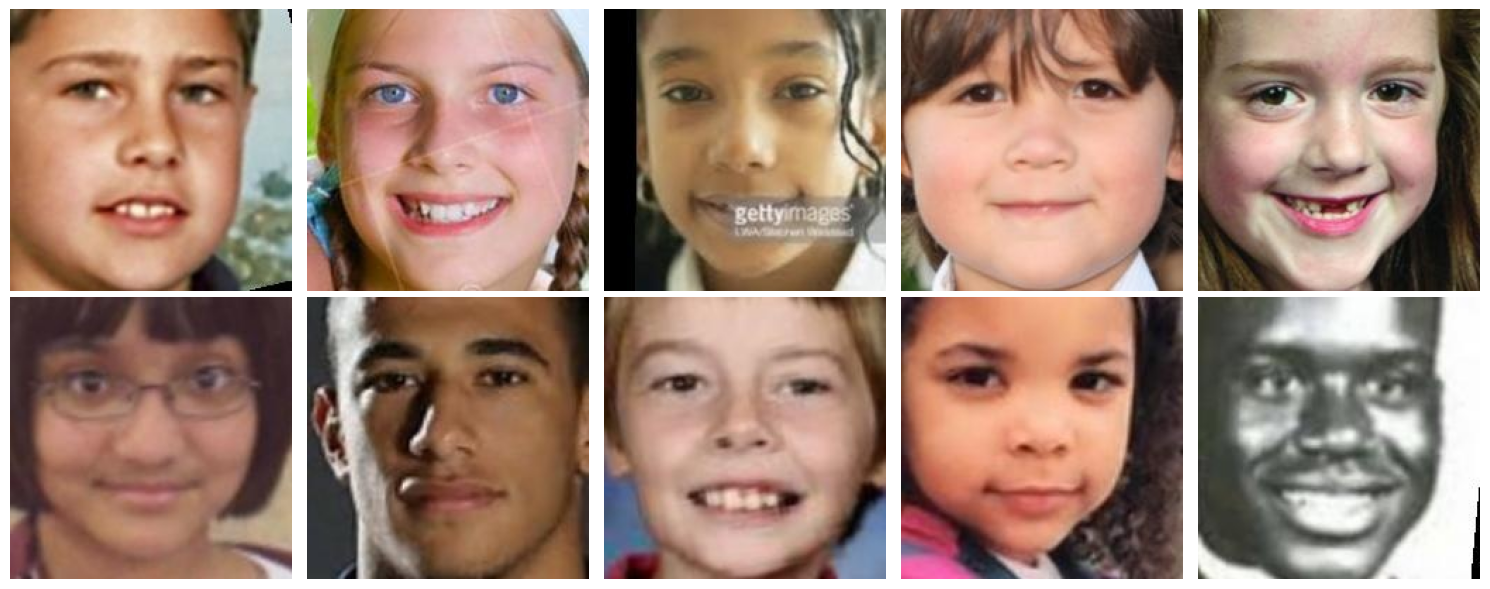

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img = Image.open(df['image_path'][i])
    row =i//5
    col =i% 5
    axes[row,col].imshow(img)
    axes[row,col].axis('off')
plt.tight_layout()
plt.show()

# Visualize Data with PIE,Bar Chart

In [3]:
# Reverse mapping from label numbers to folder names
label_to_folder = {v: k for k, v in target_name.items()}  # {0: '25-30', 1: '42-48', 2: '60-98', 3: '6-20'}

# Get the class counts
class_counts = df['label'].value_counts()

# Print class counts along with corresponding folder names
for label, count in class_counts.items():
    folder_name = label_to_folder[label]  # Get the folder name for the label
    print(f'Class {label} (Folder: {folder_name}): {count} images')

Class 3 (Folder: 60-98): 2649 images
Class 0 (Folder: 6-20): 2514 images
Class 1 (Folder: 25-30): 2495 images
Class 2 (Folder: 42-48): 1439 images


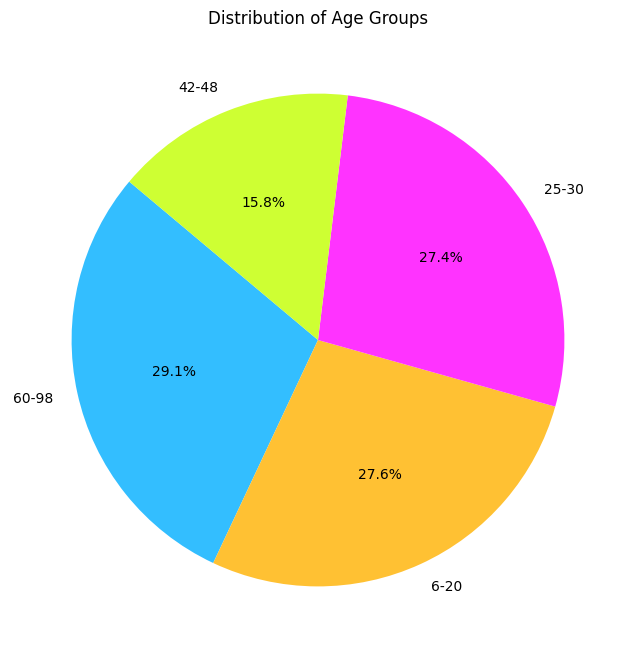

In [61]:
labs =['60-98','6-20','25-30','42-48']
# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=labs, autopct='%1.1f%%', startangle=140, colors=['#33beff','#ffc133','#ff33ff','#ceff33'])
plt.title('Distribution of Age Groups')
plt.show()

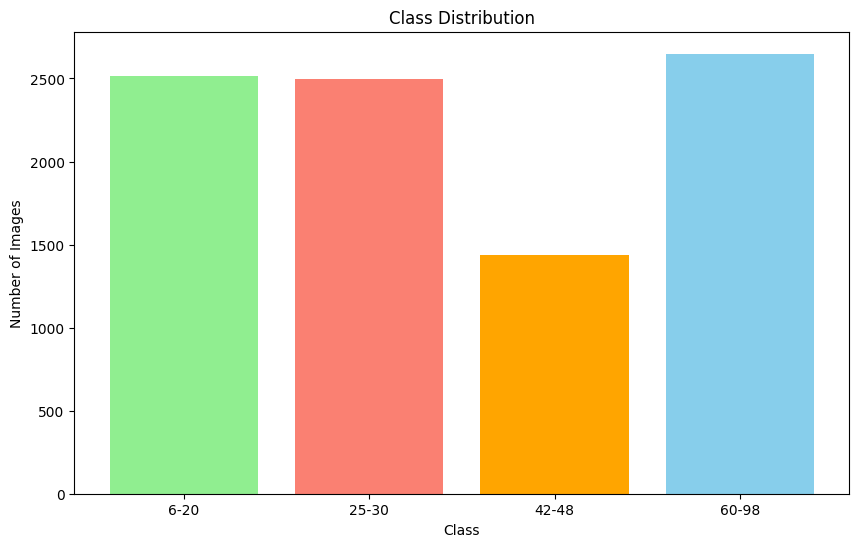

In [88]:
colors = ['skyblue', 'lightgreen', 'salmon', 'orange']
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color = colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(ticks=class_counts.index, labels=labs)
plt.show()

# Splitting Into Train,Test

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print('length of Train df : ',len(train_df))
print('length of Test df  : ',len(test_df))

length of Train df :  7277
length of Test df  :  1820


In [5]:
print('Class distribution in training set:')
print(train_df['label'].value_counts())

print('Class distribution in test set:')
print(test_df['label'].value_counts())

Class distribution in training set:
label
3    2119
0    2011
1    1996
2    1151
Name: count, dtype: int64
Class distribution in test set:
label
3    530
0    503
1    499
2    288
Name: count, dtype: int64


# Data Augumentation

In [6]:
# Convert numeric labels to strings
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
# ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rotation_range=20,        # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,    # Randomly shift images horizontally by 20%
    height_shift_range=0.2,   # Randomly shift images vertically by 20%
    shear_range=0.2,          # Shear transformations
    zoom_range=0.2,           # Randomly zoom into images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest',      # Fill in missing pixels after transformations
    rescale=1./255            # Rescale the pixel values
)

# ImageDataGenerator for test (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from the DataFrame for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',       # Column with image file paths
    y_col='label',            # Column with labels
    target_size=(80, 80),     # Resize images to 80x80
    batch_size=32,
    class_mode='categorical', # For multi-class classification (one-hot encoding)
    shuffle=True
)

# Flow images from the DataFrame for testing
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(80, 80),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data
)

Found 7277 validated image filenames belonging to 4 classes.
Found 1820 validated image filenames belonging to 4 classes.


# Create A Model

In [7]:
def create_model():
    # Load and configure the base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(80,80,3))
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [8]:
# Compile the  Model
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train Model

In [70]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Can be 'val_accuracy' or 'val_loss'
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True
)
# Model training (example)
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 147s 309ms/step - accuracy: 0.3619 - loss: 1.6975 - val_accuracy: 0.2912 - val_loss: 23.1272
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.5302 - loss: 1.0603 - val_accuracy: 0.2912 - val_loss: 3.9271
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.5955 - loss: 0.9541 - val_accuracy: 0.2918 - val_loss: 4.4876
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.6110 - loss: 0.8956 - val_accuracy: 0.6659 - val_loss: 0.8837
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.6732 - loss: 0.8163 - val_accuracy: 0.6038 - val_loss: 1.2164
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - accuracy: 0.6629 - loss: 0.8057 - val_accuracy: 0.4934 - val_loss: 1.7970
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.6691 - loss: 0.7917 - val_accuracy: 0.5538 - val_loss: 1.1877
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.6778 - loss:

### Save Model ,Download

In [71]:
model.save('age_recognition_model_1.h5')

In [73]:
import shutil

# Move the model to the Kaggle output directory
shutil.move('age_recognition_model_1.h5', '/kaggle/working/age_recognition_model_1.h5')

'/kaggle/working/age_recognition_model_1.h5'

In [14]:
model= load_model('/kaggle/input/age-detection-model/age_recognition_model_1.h5')
# model.summary()

# Visualize Loss And Accuracy

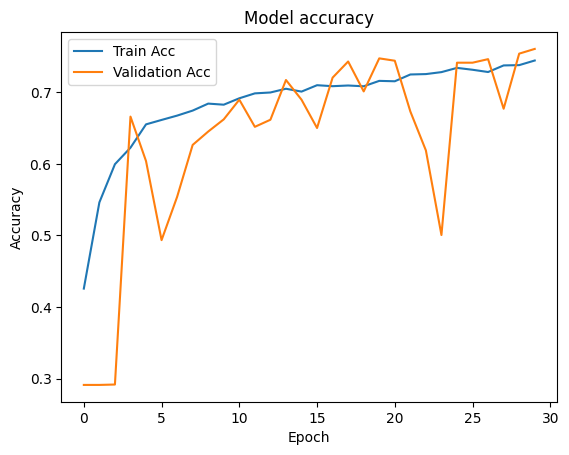

In [74]:
fig, ax = plt.subplots(1,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Validation Acc'], loc='upper left')
plt.show()

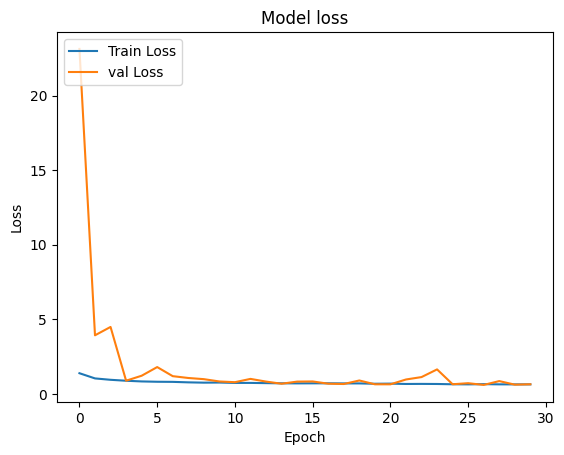

In [75]:
# Plot training & validation loss values
fig, ax = plt.subplots(1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'val Loss'], loc='upper left')
plt.show()

# Confusion Matrix

In [15]:
y_pred_prob = model.predict(validation_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725972947.999416     109 service.cc:145] XLA service 0x7af19c003610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725972947.999475     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/57 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step

I0000 00:00:1725972952.543657     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step


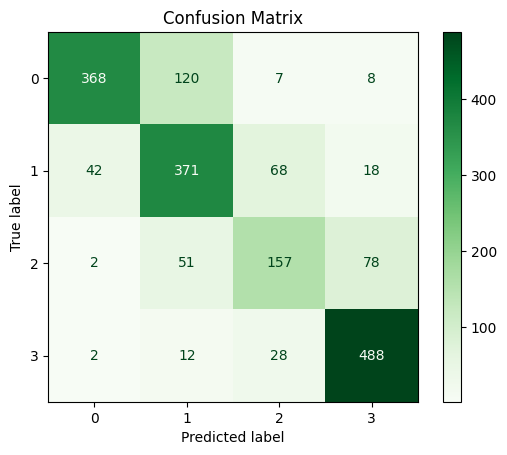

In [19]:
 # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)      # Convert probabilities to predicted class labels

# True labels
y_true = validation_generator.classes              # Get true labels from the test generator

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys(),zero_division=0))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       503
           1       0.67      0.74      0.70       499
           2       0.60      0.55      0.57       288
           3       0.82      0.92      0.87       530

    accuracy                           0.76      1820
   macro avg       0.75      0.74      0.74      1820
weighted avg       0.76      0.76      0.76      1820



# Preprocess And Predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


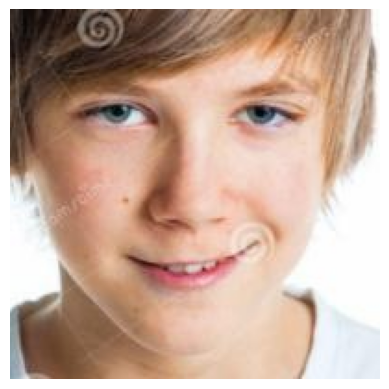

Predicted label: 6-20


In [21]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(80, 80)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to predict
# The image i take from the 25-30
#image_path = '/kaggle/input/age-recognition-dataset/Dataset/25-30/25_0_0_20170104011143168.jpg'

#This one image is between 6-20
image_path = '/kaggle/input/age-recognition-dataset/Dataset/6-20/10_0_0_20170110215927291.jpg'
img_array = load_and_preprocess_image(image_path)

# Predict the class probabilities
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Display the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the predicted class label
class_names = ['6-20','25-30', '42-48', '60-98']
predicted_label = class_names[predicted_class[0]]
print(f'Predicted label: {predicted_label}')